# Tetrahedral site occupation analysis

This notebook performs a site-occupation analysis of the Li<sub>6</sub>PS<sub>5</sub><i>X</i> molecular dynamics simulation trajectories, based on assigning lithium ions at each simulation timestep to one of a set of tetrahedral interstitial sites.

The analysis is performed using the [`site_analysis`](https://site-analysis.readthedocs.io) module, and consists of the following steps:
1. For each tetrahedral site type, construct a reference structure containing atoms placed at each of these tetrahedral site positions.
2. Construct an &ldquo;anion reference structure&rdquo; containing S atoms at each of the the argyrodite anion positions.
3. Taking the sequence of pymatgen `Structure`s from each MD simulation:
    1. For the first structure in each MD simulation, we map each anion onto the nearest &ldquo;ideal&rdquo; anion site. The maximum distance we move any anion is printed. Large maximum mapping distances indicate the anion lattice in the MD structure is significantly distorted with respect to the ideal anion sublattice, which may introduct artefacts into the subsequent polyhedral analysis.
    2. For each ideal cation site, we then find the site indices of the four nearest neighbours in this structure. This gives us the site indices of the vertex atoms that define each tetrahedral site.
    3. Using the vertex indices, we construct a set of &ldquo;coordination polyhedra&rdquo; as  `site_analysis.CoordinationPolyehdra` objects.
    4. We then perform a trajectory analysis on the full MD trajectory. At each timestep the mobile Li atoms are assigned to one of the tetrahedral coordination polyhedra.
4. We can then query the resulting `site_analysis.Trajectory` object to exctract the populations of the occupied tetrahedral sites.


In [1]:
import yaml
from pymatgen.io.vasp import Xdatcar
import matplotlib.pyplot as plt
from site_analysis_functions import tetrahedral_site_analysis
from site_analysis_functions import site_populations
import numpy as np

import sys
sys.path.insert(0, "../../scripts/")
from utils import flatten_list

In [2]:
with open('../md_runs.yaml', 'r') as f:
    md_runs = yaml.safe_load(f)
print(md_runs)

{'Li6PS5I': {'0p': [1, 2, 3, 4, 5, 6], '50p': [1, 2, 3, 4, 5, 6, 7], '100p': [1, 2, 3, 4, 5, 6, 7]}, 'Li6PS5Cl': {'0p': [1, 2, 3, 4, 5], '50p': [1, 2, 3, 4, 5, 6], '100p': [1, 2, 3, 4, 5, 6]}}


In [3]:
data_dir = '../../data'

x_spec = {'Li6PS5I': 'I', 'Li6PS5Cl': 'Cl'}

trajectory = {}
populations = {}
for system in md_runs:
    trajectory[system] = {}
    populations[system] = {}
    for disorder, runs in md_runs[system].items():
        print(f'Analysing {system}: {disorder}')
        xdatcar_filenames = [f'{data_dir}/{system}/{disorder}/run{i}/inherent_XDATCAR.gz' for i in runs]
        xdatcars = (Xdatcar(f) for f in xdatcar_filenames)
        structures = flatten_list([x.structures for x in xdatcars])
        trajectory[system][disorder] = tetrahedral_site_analysis(structures, x_spec[system])
        populations[system][disorder] = site_populations(trajectory[system][disorder])

Analysing Li6PS5I: 0p
max mapping disp = 0.26 Angstroms


100%|██████████| 700/700 [14:27<00:00,  1.24s/ steps]


Analysing Li6PS5I: 50p
max mapping disp = 0.58 Angstroms


100%|██████████| 700/700 [08:26<00:00,  1.38 steps/s]


Analysing Li6PS5I: 100p
max mapping disp = 0.43 Angstroms


100%|██████████| 700/700 [06:59<00:00,  1.67 steps/s]


Analysing Li6PS5Cl: 0p
max mapping disp = 0.89 Angstroms


100%|██████████| 700/700 [15:55<00:00,  1.37s/ steps]


Analysing Li6PS5Cl: 50p
max mapping disp = 0.78 Angstroms


100%|██████████| 700/700 [12:44<00:00,  1.09s/ steps]


Analysing Li6PS5Cl: 100p
max mapping disp = 0.60 Angstroms


100%|██████████| 700/700 [11:56<00:00,  1.02s/ steps]


In [4]:
from matplotlib import rcParams

rcParams['font.serif'] = "Iowan Old Style"
rcParams['font.family'] = "serif"

rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Iowan Old Style'
rcParams['mathtext.it'] = 'Iowan Old Style:italic'
rcParams['mathtext.bf'] = 'Iowan Old Style:bold'


rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams.update({'font.size': 16})
rcParams['text.usetex']=False

/Users/bjm42/.pyenv/versions/3.7.7/envs/argyrodites/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


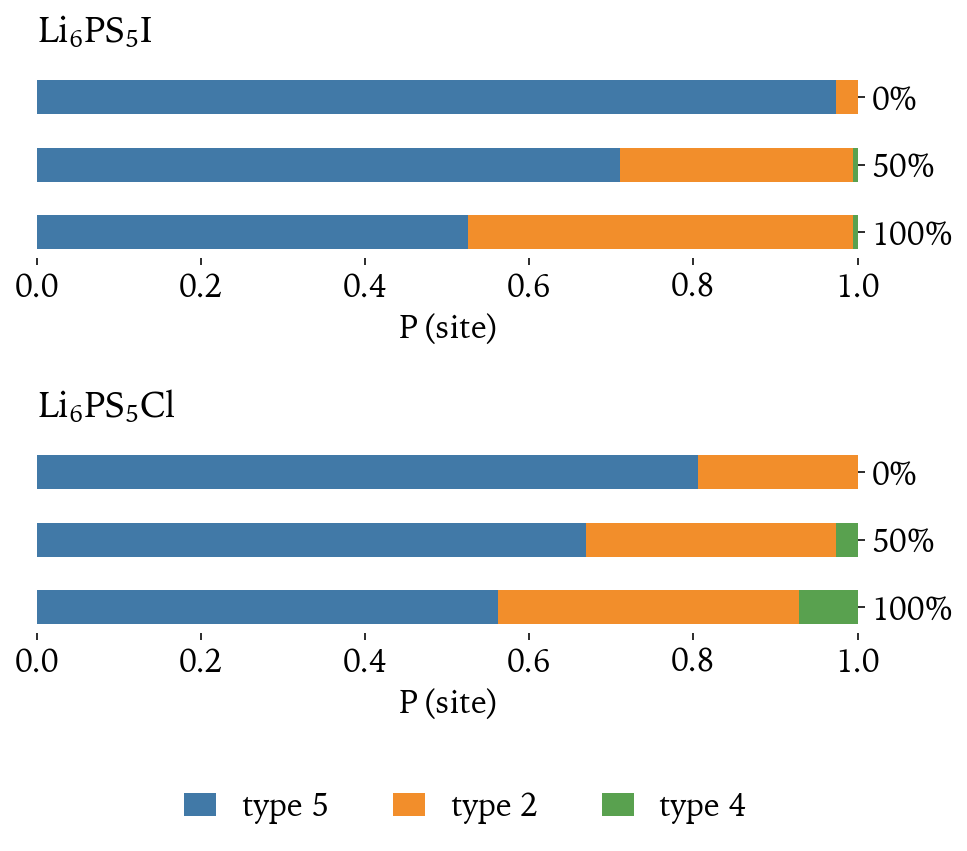

In [5]:
ind = np.arange(3)
fig, ax = plt.subplots(2,1, figsize=(7,7))
title = { 'Li6PS5I': r'Li$_6$PS$_5$I',
          'Li6PS5Cl': r'Li$_6$PS$_5$Cl'}

color = {'5': '#4179a7',
         '2': '#f28e2b',
         '4': '#59a14f',
         '3': '#ef9da7', 
         '1': '#bab0ac',
         '0': '#9f9f9f'}

for j, system in enumerate(['Li6PS5I', 'Li6PS5Cl']):
    bottom = np.zeros(3)
    for i in [5, 2, 4, 3, 1, 0]:
        heights = [ populations[system]['0p'][str(i)],
                    populations[system]['50p'][str(i)],
                    populations[system]['100p'][str(i)] ]

        heights.reverse()

        width=0.5
        ax[j].barh(ind, heights, width, left=bottom, label=f'{i}', color=color[str(i)])
        bottom += heights
    ax[j].set_xlabel(r'$P\,(\mathrm{site})$')
    ax[j].set_yticklabels(['100%', '50%', '0%'])
    ax[j].set_yticks([0,1,2])
    ax[j].yaxis.tick_right()
    ax[j].set_title(title[system], pad=15, loc='left', fontsize=18)
    ax[j].spines['right'].set_visible(False)
    ax[j].spines['top'].set_visible(False)
    ax[j].spines['left'].set_visible(False)
    ax[j].spines['bottom'].set_visible(False)
handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(handles[0:3], ['type 5', 'type 2', 'type 4'],
             bbox_to_anchor=(0.9,-0.7), ncol=6, handlelength=1, frameon=False)
plt.tight_layout()
plt.savefig('../../figures/tetrahedral_site_populations.pdf', bbox_inches='tight')
plt.show()

In [6]:
populations

{'Li6PS5I': {'0p': {'0': 0.0,
   '1': 0.0,
   '2': 0.02654761904761905,
   '3': 0.0,
   '4': 0.0,
   '5': 0.973452380952381},
  '50p': {'0': 0.0,
   '1': 0.0,
   '2': 0.28404017857142855,
   '3': 0.0,
   '4': 0.0056770833333333335,
   '5': 0.7102827380952381},
  '100p': {'0': 0.0,
   '1': 0.0,
   '2': 0.468891369047619,
   '3': 0.0,
   '4': 0.005446428571428572,
   '5': 0.5256622023809524}},
 'Li6PS5Cl': {'0p': {'0': 0.0,
   '1': 8.184523809523809e-05,
   '2': 0.19406994047619047,
   '3': 0.0,
   '4': 7.4404761904761905e-06,
   '5': 0.8058407738095238},
  '50p': {'0': 0.0,
   '1': 2.9761904761904762e-05,
   '2': 0.30372767857142857,
   '3': 0.0,
   '4': 0.026569940476190476,
   '5': 0.6696726190476191},
  '100p': {'0': 0.0,
   '1': 0.0,
   '2': 0.3675372023809524,
   '3': 0.0,
   '4': 0.07099702380952382,
   '5': 0.5614657738095238}}}

In [ ]:
%load_ext version_information

%version_information yaml, pymatgen, tqdm, numpy, site_analysis, matplotlib